### Least Squares

**Definition: Supervised learning**

> Given a $N \times p$ matrix $\textbf{X}$ and some associated output vector $\textbf{Y} \in \mathbb{R}^N$,
 find a function $f(X) = \hat{Y}$ that takes a vector $X \in \mathbb{R}^p$ and returns a prediction for $\hat{Y}$
 where some "loss function" $L(Y, f(X))$ is minimized for all $X$.

__The task:__

Given a vector $\boldsymbol{X} = (\text{blood pressure, BMI, age})$ can we find a function $f_\text{disease progression}(x) \in \{\text{stable, worse}\}$ that accurately predicts the pregression of the disease of the patients in most cases?

To get some sense of the quality of this predictor, we gather the following numbers:

* __True Positives__ $\textbf{TP}$, number of correctly predicted events as positive
* __False Positives__ $\textbf{FP}$, number of events falsely predicted as positive which belong to negative
* __True Negatives__ $\textbf{TN}$, number of correctly predicted events as negative
* __False Negatives__ $\textbf{FN}$, number of events falsely predicted as negative which belong to positive

This is visualised in the so called confusion matrix: 
$$
\begin{pmatrix}
TP & FP \\
FN & TN
\end{pmatrix}
$$
We can look at the fraction of correctly labeled observations in the data

$$
    \text{accuracy}(\v{y}, \v{\hat{y}}) = \frac{1}{N} \sum_{i = 1}^N \mathbb{1}(y_i = \hat{y}_i)
$$

or simply put 

$$
    \text{accuracy}(\v{y}, \v{\hat{y}}) =  \frac{\textbf{TP} + \textbf{TN}}{ \textbf{TP} + \textbf{FP} + \textbf{FN} + \textbf{TN}} = \frac{\text{correctly predicted observations}}{\text{total number of observations}}.
$$


Now we try to find a function where the accuracy is higher than 0.5

In [1]:
?load_diabetes

Object `load_diabetes` not found.


In [2]:
import pandas as pd
from sklearn.datasets import load_diabetes

# load dataset
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df["target"] = diabetes.target

n = 5
print(f"First {n} rows of the diabetes dataset:")
print(df.head(n))

First 5 rows of the diabetes dataset:
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0  


In [3]:
import numpy as np

y = diabetes.target

# min and max value
y_min, y_max = np.min(y), np.max(y)
print("Min target:", y_min)
print("Max target:", y_max)

# Use median as threshold (for classification later)
threshold = np.mean(y)
print("Median (threshold):", threshold)

print(f"""
Interpretation:
- values <= to {threshold:.1f} = disease more stable
- values > {threshold:.1f} = disease has gotten worse
""")

Min target: 25.0
Max target: 346.0
Median (threshold): 152.13348416289594

Interpretation:
- values <= to 152.1 = disease more stable
- values > 152.1 = disease has gotten worse



In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix


def plot_bars_and_confusion(
    truth,
    prediction,
    axes=None,
    vmin=None,
    vmax=None,
    cmap="viridis",
    title=None,
    bar_color=None,
):
    accuracy = accuracy_score(truth, prediction)
    cm = confusion_matrix(truth, prediction)

    if not isinstance(truth, pd.Series):
        truth = pd.Series(truth)

    if not isinstance(prediction, pd.Series):
        prediction = pd.Series(prediction)

    correct = pd.Series(truth.values == prediction.values)

    truth.sort_index(inplace=True)
    prediction.sort_index(inplace=True)

    if not axes:
        fig, axes = plt.subplots(1, 2, figsize=(8, 2))

    if not vmin:
        vmin = cm.min()

    if not vmax:
        vmax = cm.max()

    if not bar_color:
        correct.value_counts().plot.barh(ax=axes[0])
    else:
        correct.value_counts().plot.barh(ax=axes[0], color=bar_color)

    axes[0].text(150, 0.5, "Accuracy {:0.3f}".format(accuracy))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        xticklabels=["False", "True"],
        yticklabels=["False", "True"],
        ax=axes[1],
        vmin=vmin,
        vmax=vmax,
    )
    axes[1].set_ylabel("Truth")
    axes[1].set_xlabel("Predicted")
    if title:
        plt.suptitle(title)
    plt.show()

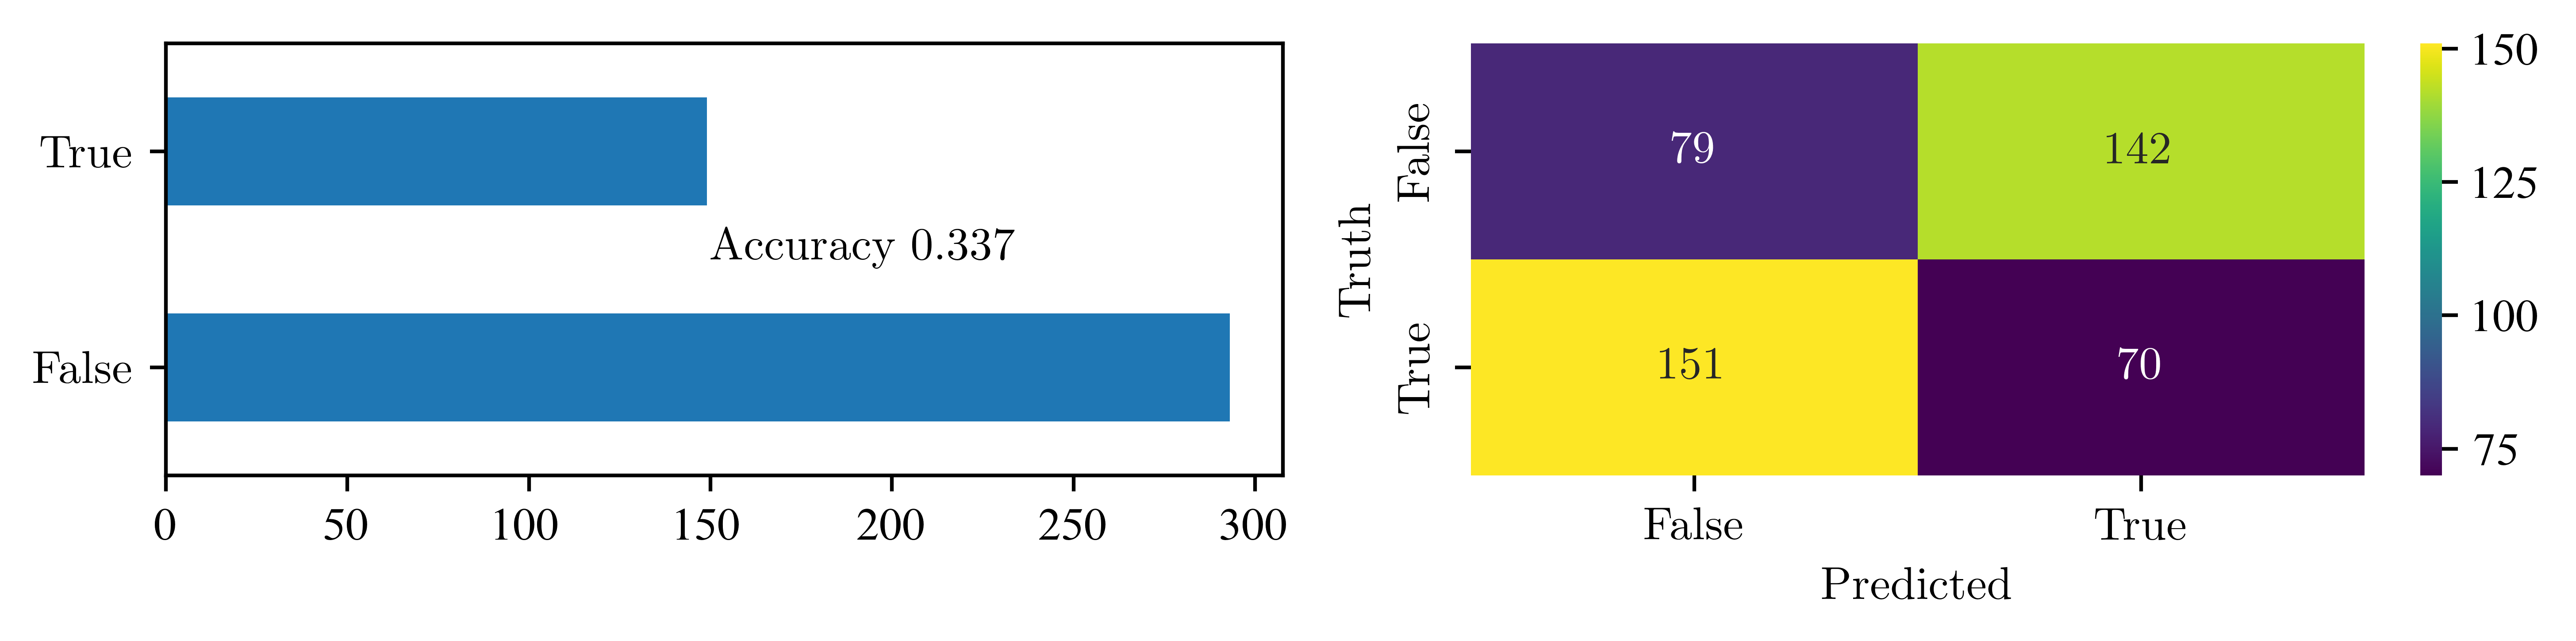

In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes


def disease_prediction(truth, feature):
    x = df[feature]
    threshold_feature = np.median(x)
    x_bin = (x < threshold_feature).astype(int)
    prediction = x_bin

    plot_bars_and_confusion(truth=truth, prediction=prediction)


# load data
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df["target"] = diabetes.target

# threshold for disease progression
y = diabetes.target
threshold_truth = np.median(y)
y_bin = (y > threshold_truth).astype(int)  # 1 = worse, 0 = stable

# disease_prediction(y_bin, "bmi")
disease_prediction(y_bin, "bp")
# disease_prediction(y_bin, "age")

### Linear Models

Can we improve our predictor by combining more variables into one predictor?

Lets assume a linear weighted combination of variables:

$\def\RSS{\operatorname{RSS}}$

$$
f(x)= \hat{y} =  \hat{\beta}_0 + \sum_{j=1}^p x_j \hat{\beta}_j,
$$
where $f:\mathbb{R}^{p} \to \mathbb{R}$.

For a single sample of the diabetes data we simply evaluate:
$$
f(x)= \hat{\beta}_0 + x_{BMI} \hat{\beta}_1 + x_{BP} \hat{\beta}_2.
$$

When we include a 1 as the first entry into our sample $\v{x}$ e.g. $\v{x} = (1, x_1, x_2, \ldots, x_p)$ we can rewrite $f$ in matrix form

$$
f(x)= \hat{y} =  \v{x}^\top \v{\beta},
$$

where $\v{\beta} = (\beta_0, \beta_1, \beta_2, \ldots, \beta_p)$.



How do you find those weights? Like before we choose a loss function and try to opimize it.
The loss function measures the error for a single training example (i.e., how far the model's prediction is from the actual target).
In this case we choose a loss function called the residual sum of squares (RSS).
We calculate it over all samples $x_i$ in a matrix $\boldsymbol{X}$.

$$L(\v{\beta}) = \RSS(\v{\beta}) = \sum_{i=1}^N (y_i - \v{x}_i^\top \v\beta)^2. $$
Remark: Here $\v{x}_i$ is a row in $\v{X}$, hence the transpose.

Now we rewrite the loss function in matrix form:


$$
\RSS(\v\beta) = (\v{y} - \textbf{X} \v\beta)^\top (\v{y} - \textbf{X} \v\beta )
$$

and we optimize the loss function just like we would any other function, by differentiating with respect to $\v\beta$ and setting the result equals to zero.

We need the product rule:
$$
\frac{\partial({\v{u}} \cdot {\v{v}})}{\partial{\v{x}}}= 
 \v{u}^\top \frac{\partial \v{v}}{\partial \v{x}} + \v{v}^\top \frac{\partial \v{u}}{\partial \v{x}},
$$

this yields
$$
 2 \cdot \textbf{X}^T (\v{y} - \textbf{X} \v\beta ) \stackrel{!}{=} 0.
$$

Solving for $\v\beta$ leads to

$$
\hat{\v\beta} = (\textbf{X}^\top \textbf{X})^{-1} \textbf{X}^\top \v{y}.
$$


We just performed  __Linear Least Squares__ regression.

Now we can define a function to predict disease progression according to

$$
\hat{y} = \begin{cases}
\text{Worse}, & \text{if $ f(x) \gt 0.5$} \\
\text{Stable}, & \text{if $ f(x) \le 0.5$}
\end{cases}
$$ 



### Linear Regression with sklearn

__Goal__: Create a 2D dataset with two classes and use the least squares method to seperate them.


1. Create random points in a 2D parameter space
    ```python
    from sklearn.datasets import make_blobs
    ```
2. Use scikit-learn's linear regressor to find the parameters for $f(X_1, X_2) = \hat{Y}$.
    ```python
    from sklearn import linear_model
    regression = linear_model.LinearRegression()
    regression.fit(X, Y)
    b_1, b_2 = regression.coef_
    b_0 = regression.intercept_
    ```
3. Draw a dashed line into the plot where $f(X_1, X_2) = 0.5$.
    ```python
    x1 = np.linspace(-2, 2)
    x2 = ...
    plt.plot(x1, x2, color='gray', linestyle='--')
    ```


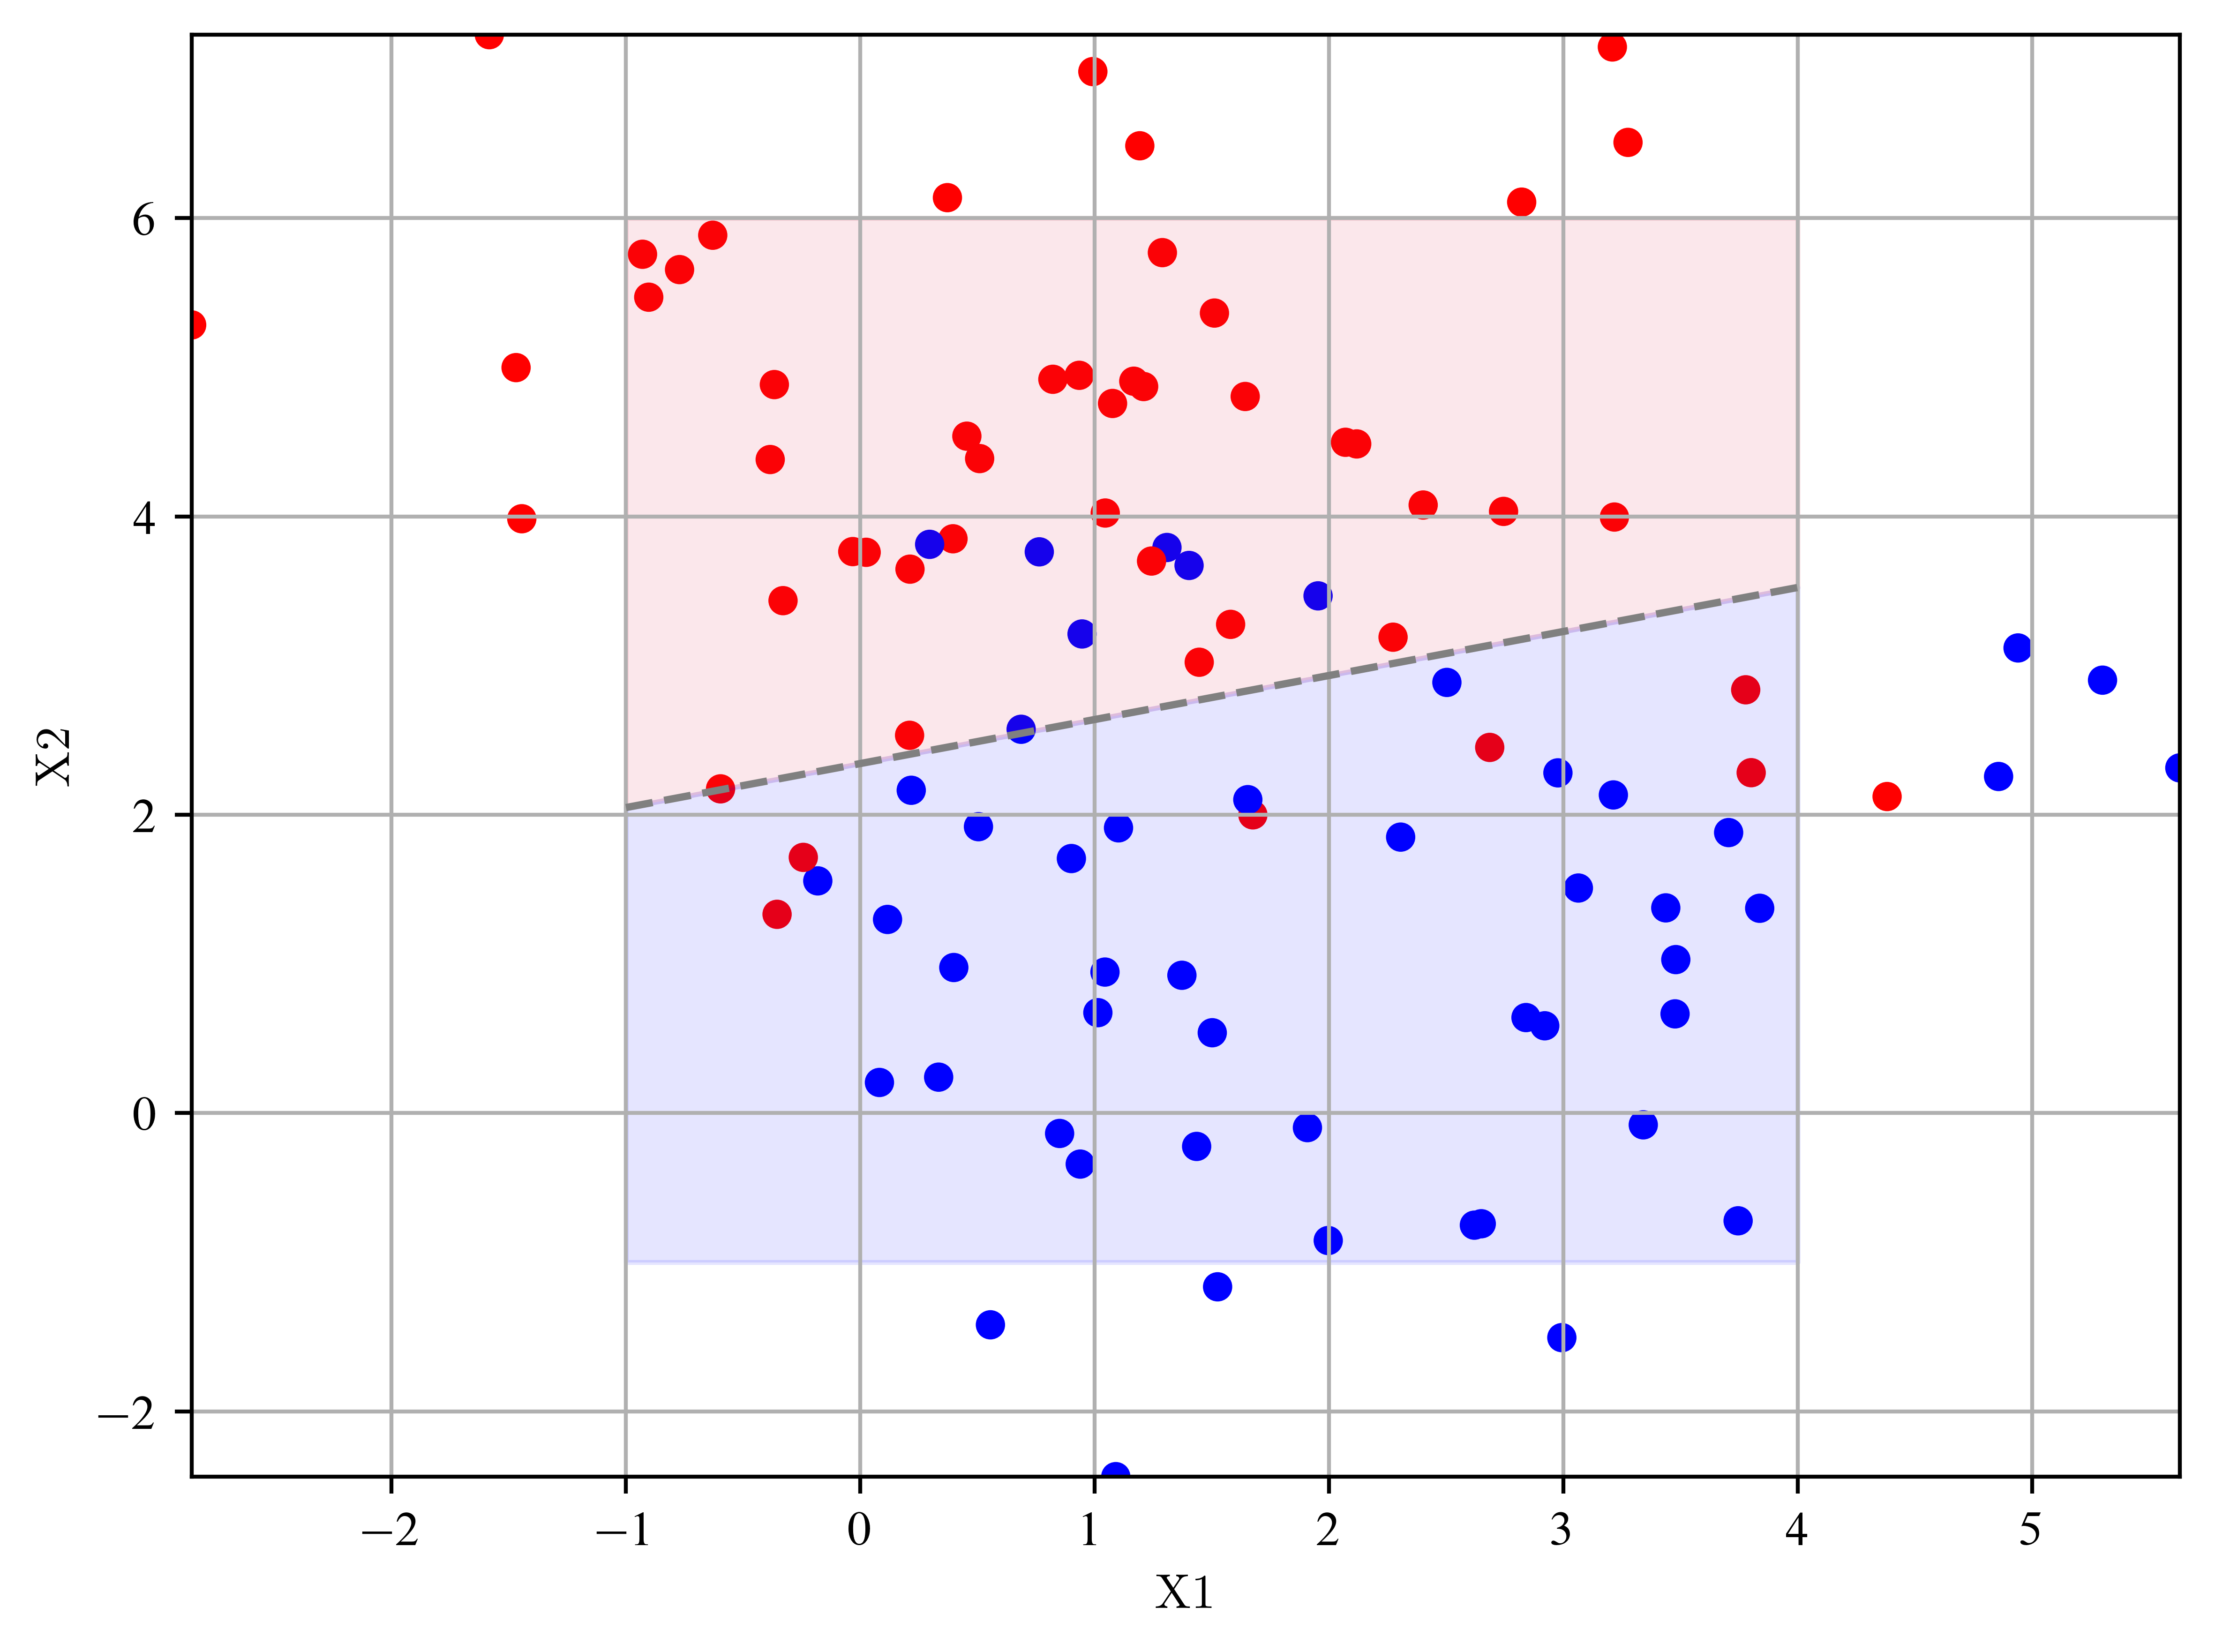

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import linear_model
from sklearn.datasets import make_blobs

# create example data
X, y = make_blobs(n_samples=100, centers=2, cluster_std=1.5, random_state=0)

# train the linear regressor and save the coefficents
# y = b0 + b1x1 + b2x2
regression = linear_model.LinearRegression()  # creates empty object
regression.fit(X, y)
b_1, b_2 = regression.coef_  # weights
b_0 = regression.intercept_  # bias

# solve the function y = b_0 + b_1*X_1 + b_2 * X_2 for X2
# remember: y is either > 0.5 or <= 0.5
x1 = np.linspace(-1, 4)
x2 = (0.5 - b_0 - b_1 * x1) / b_2

discrete_cmap = ListedColormap(["red", "blue"])
plt.scatter(X[:, 0], X[:, 1], s=25, c=y, cmap=discrete_cmap)

plt.plot(x1, x2, color="gray", linestyle="--")  # draws line for y >= / < 0.5

plt.fill_between(x1, x2, 6, color="crimson", alpha=0.1)
plt.fill_between(x1, x2, -1, color="blue", alpha=0.1)

plt.grid()
plt.xlabel("X1")
plt.ylabel("X2")
plt.margins(x=0, y=0)
plt.show()

/tmp/ipykernel_123479/1633364373.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap("bwr", 2),


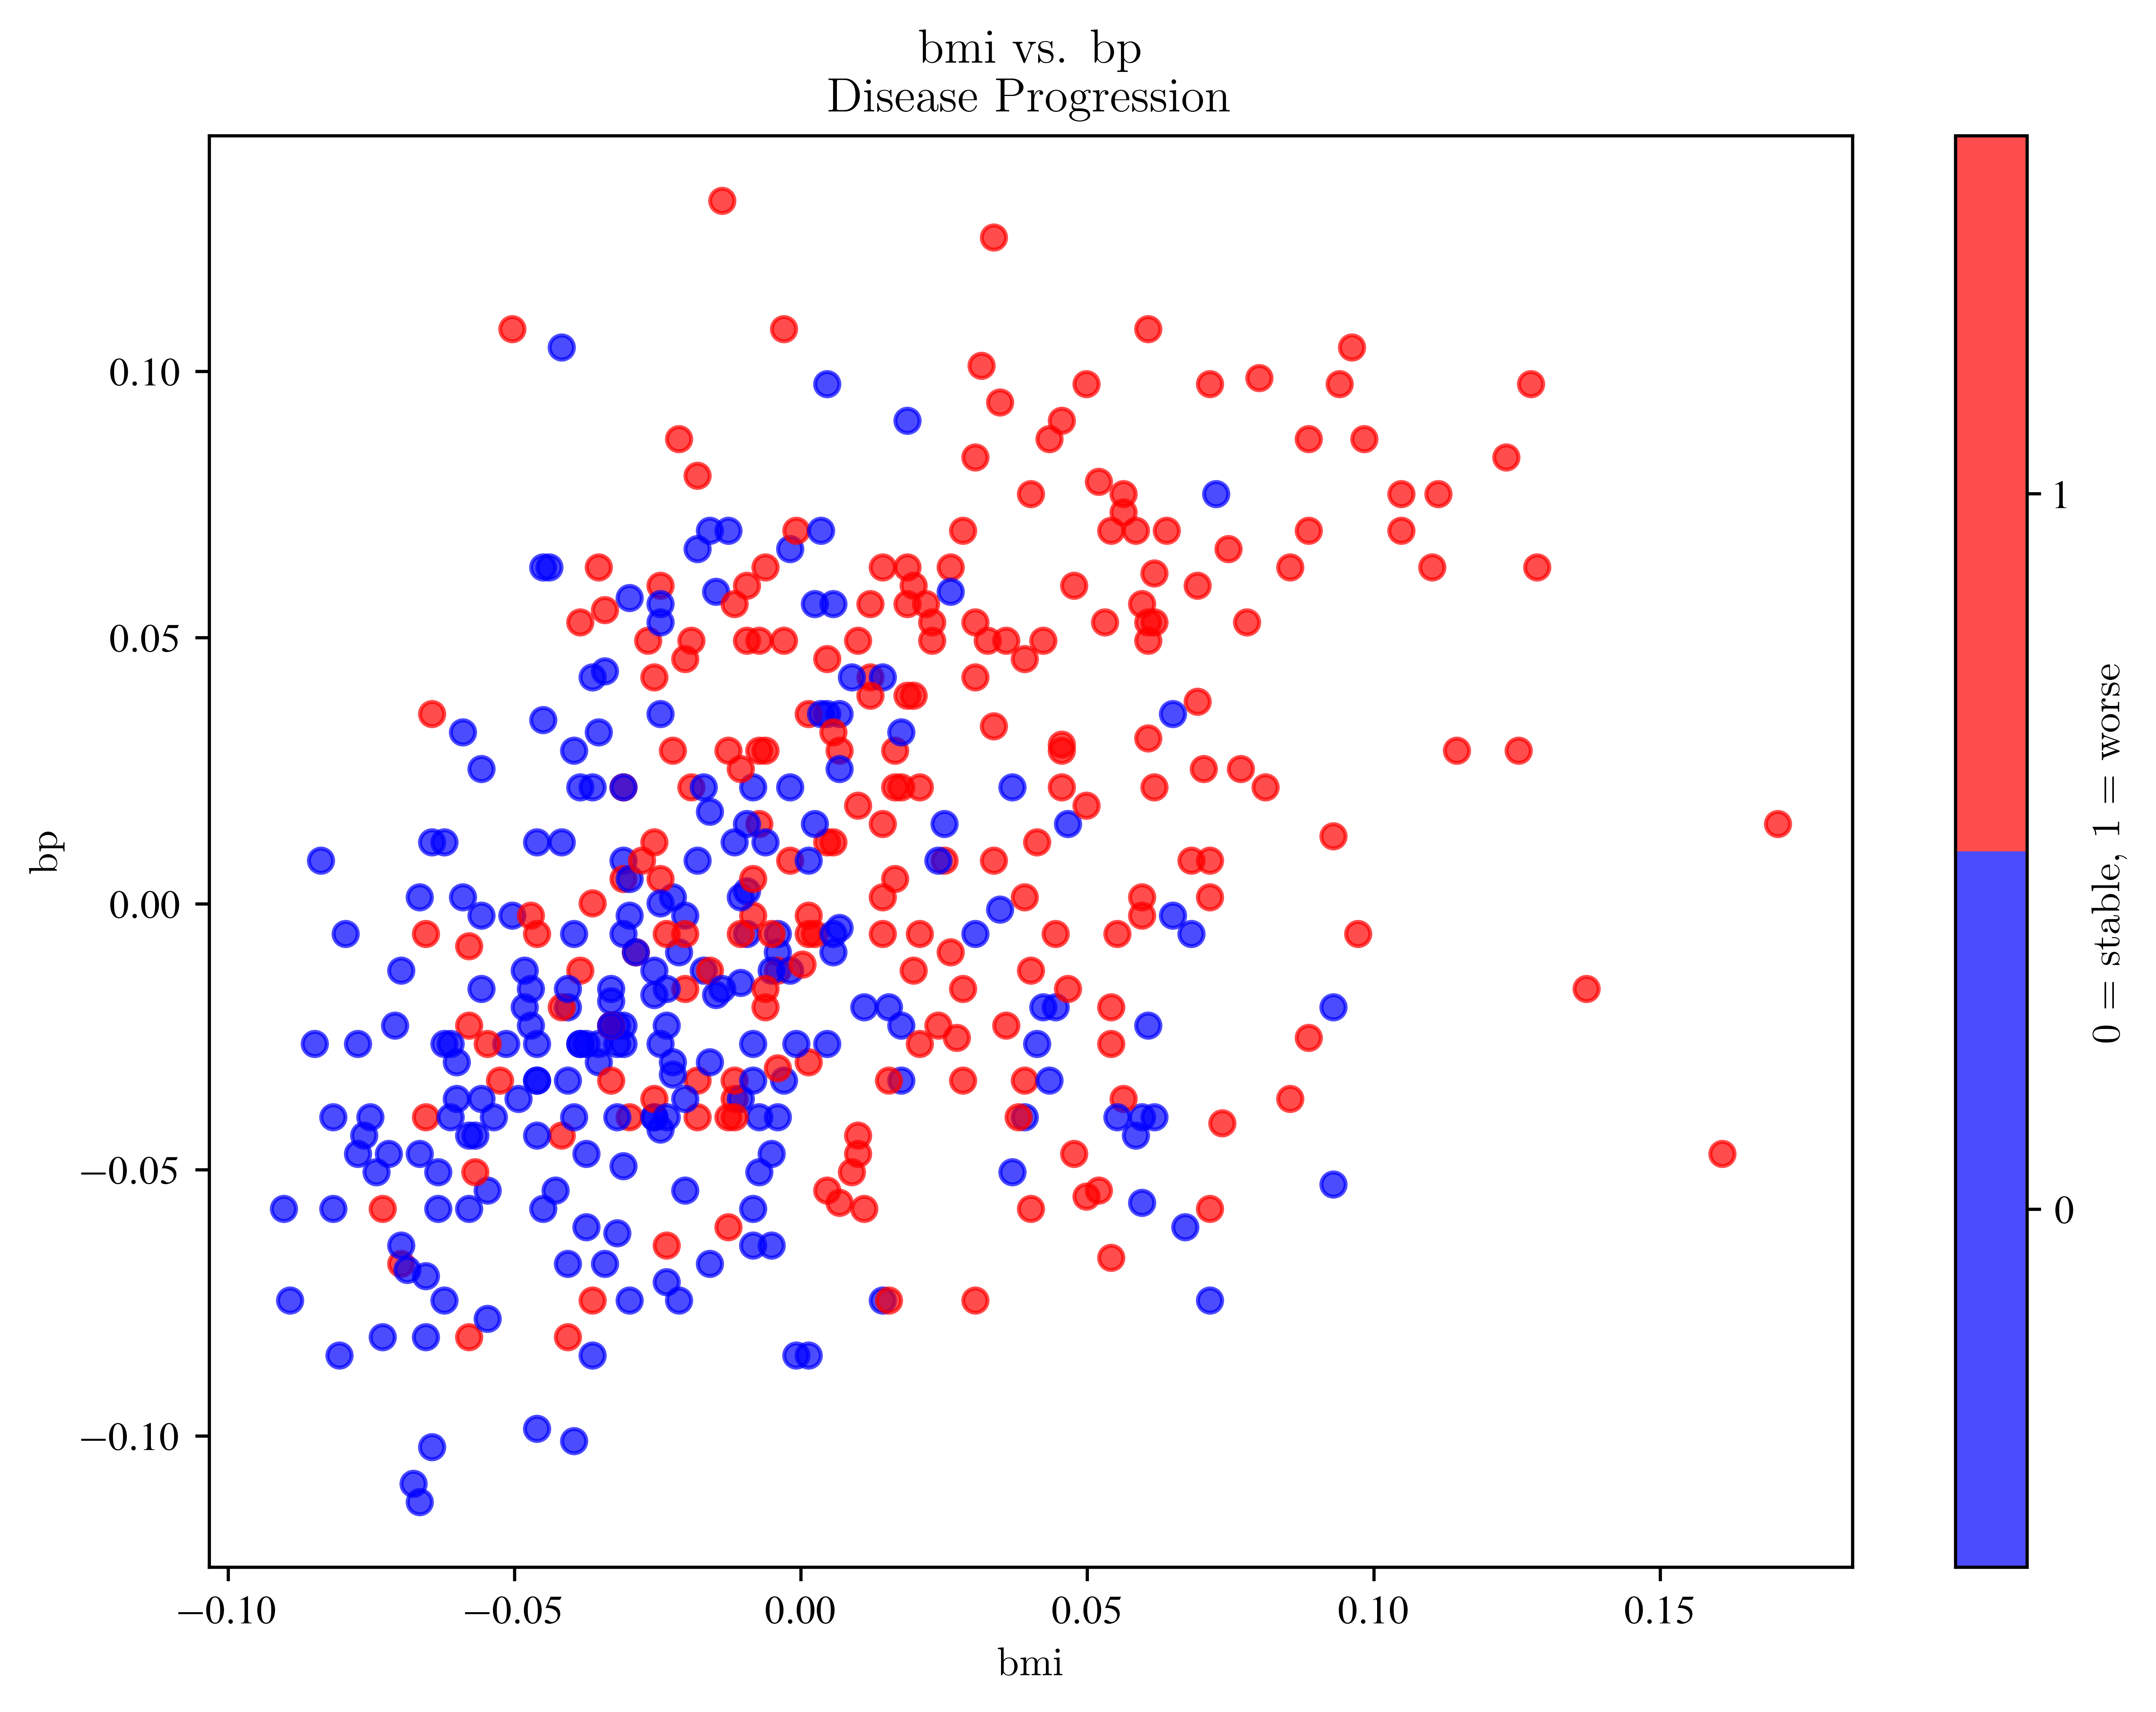

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes

# Load data
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df["target"] = diabetes.target

# Create progression classes (1 = worse, 0 = stable)
# target is continious, make a binary class out of it by creating a threshold
threshold = np.median(df["target"])
df["progression_class"] = (df["target"] > threshold).astype(int)


# --- Function for scatterplot ---
def plot_progression(feature_x, feature_y, data=df):
    fig, ax = plt.subplots(figsize=(8, 6))

    sc = ax.scatter(
        data[feature_x],
        data[feature_y],
        c=data["progression_class"],
        cmap=plt.cm.get_cmap("bwr", 2),
        vmin=-0.5,
        vmax=1.5,
        alpha=0.7,
    )

    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.set_title(f"{feature_x} vs. {feature_y}\nDisease Progression")

    cbar = fig.colorbar(sc, ticks=[0, 1], label="0 = stable, 1 = worse")


plot_progression("bmi", "bp")
# plot_progression("bmi", "age")

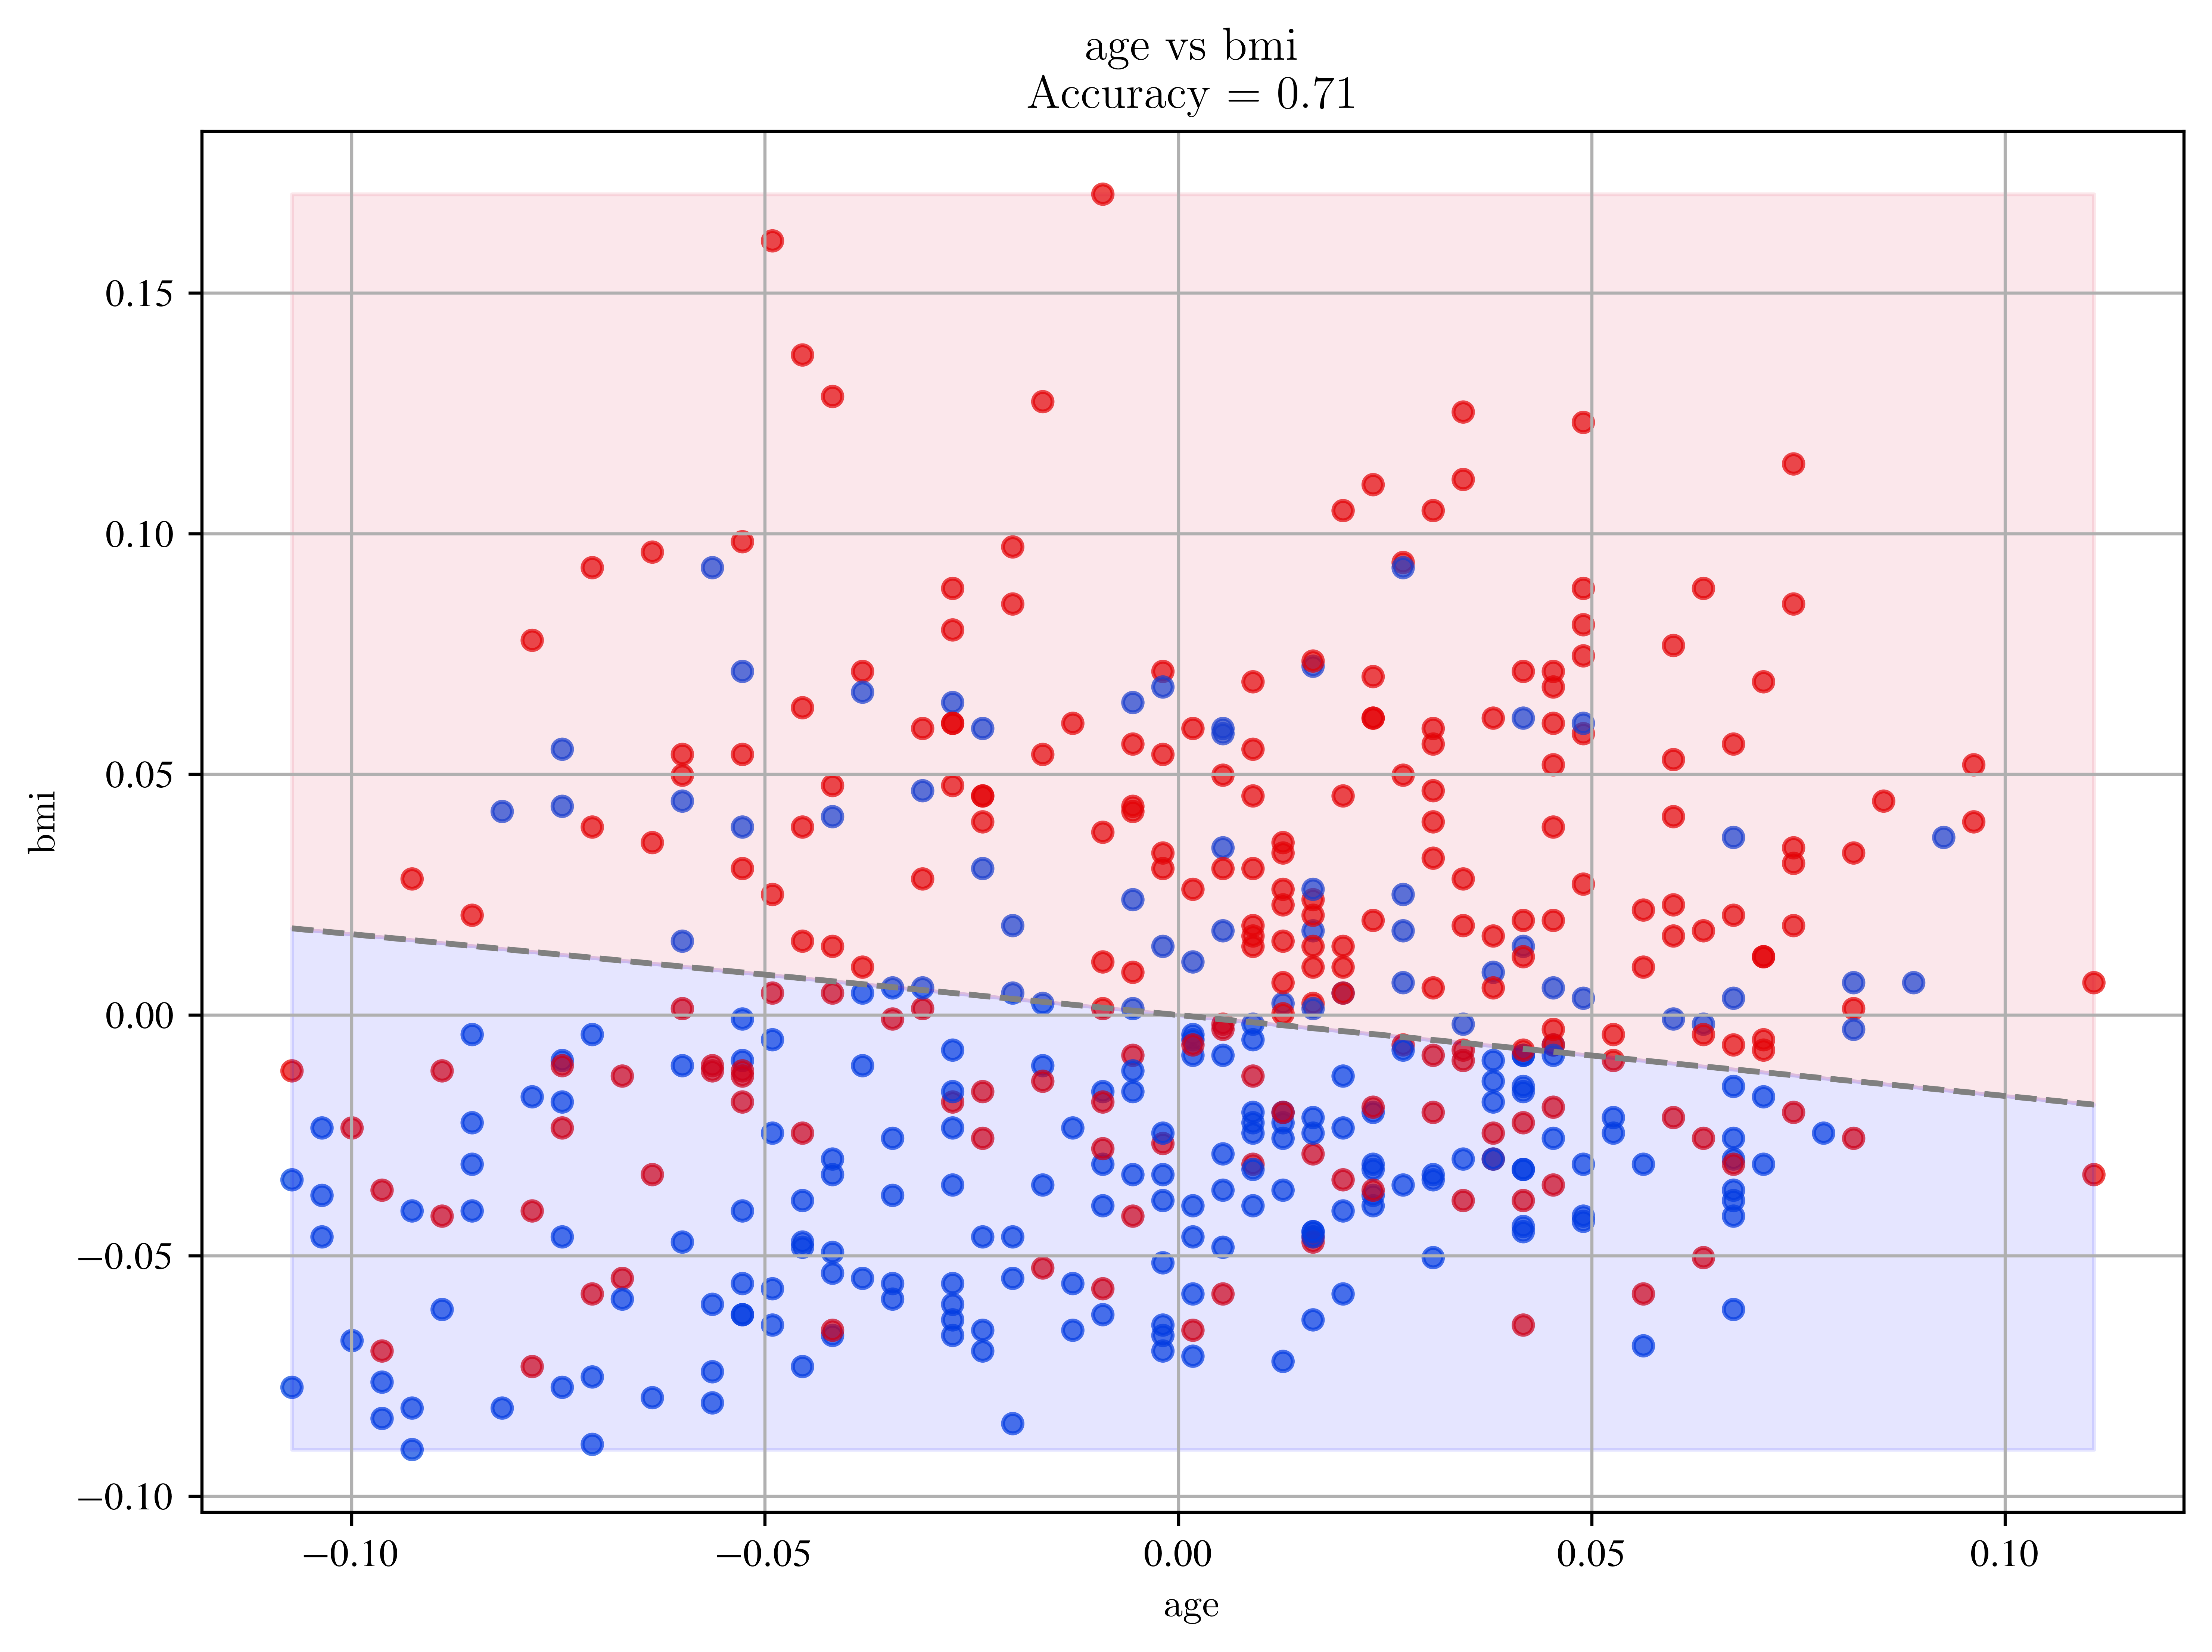

Confusion Matrix (age vs bmi):
[[168  53]
 [ 75 146]]
Accuracy: 0.710


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Load data
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df["target"] = diabetes.target

# Binary disease progression (0 = stable, 1 = worse)
threshold = np.median(df["target"])
df["progression_class"] = (df["target"] > threshold).astype(int)


# --- Function: scatter + regression boundary + accuracy ---
def plot_progression_with_regression(feature_x, feature_y, data=df):
    X = data[[feature_x, feature_y]].values
    y = data["progression_class"].values

    # Train linear regression
    regression = LinearRegression()
    regression.fit(X, y)
    b_1, b_2 = regression.coef_
    b_0 = regression.intercept_

    # Predict & classify
    y_pred = regression.predict(X)
    y_pred_class = (y_pred >= 0.5).astype(int)

    # Accuracy & Confusion Matrix
    acc = accuracy_score(y, y_pred_class)
    cm = confusion_matrix(y, y_pred_class)

    # Decision boundary: where prediction = 0.5
    x1s = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    x2s = (0.5 - b_0 - b_1 * x1s) / b_2

    # Scatterplot
    discrete_cmap = ListedColormap(["xkcd:blue", "xkcd:red"])
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=discrete_cmap, s=25, alpha=0.7)
    plt.plot(x1s, x2s, color="gray", linestyle="--")
    plt.fill_between(x1s, x2s, X[:, 1].max(), color="crimson", alpha=0.1)
    plt.fill_between(x1s, x2s, X[:, 1].min(), color="blue", alpha=0.1)

    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f"{feature_x} vs {feature_y}\nAccuracy = {acc:.2f}")
    plt.grid()
    plt.show()

    print(f"Confusion Matrix ({feature_x} vs {feature_y}):\n{cm}")
    print(f"Accuracy: {acc:.3f}")


# --- Example usage ---
# plot_progression_with_regression("bmi", "bp")
plot_progression_with_regression("age", "bmi")

__Idea of Least Squares__: Minimisation of the sum of the differences between measurement and model = minimisation of the sum of the differences of the resiuals. It is assumed that individual measurements fluctuate with _known variance_ and are _unbiased_ (residual of measurement $y_i$ is zero)

### General formulation of the Least Squares Method ###

Given a set of $n$ unbiased measurements $y_i$, $i = 1, \dots, n$ with known covariance matrix $C$
and a parametric model $m_i(a)$, an estimate $\hat{a}$ for the parameters $a$ is obtained by the
minimum of a function $\chi^2(a)$, defined as


$$
\chi^2(a) = \sum_{i,j=1}^n (y_i - m_i(a))\, W_{ij} \,(y_j - m_j(a)) ,
$$

or in matrix notation

$$
\chi^2(a) = (y - m(a))^T \cdot W \cdot (y - m(a)) ,
$$

where the weight matrix $W$ defines a metric for the difference between data and model.

__Remarks__


* in many cases the preferred weight matrix is $W = C^{-1}$
* here we look only at linear models $m(a) = M a$, but also possible to use non-linear models
* the cost function $\chi^2(a)$ can be interpreted as a distance between data and model and the best fit parameters minimize the distance
* when distances are measured in units of uncertainty $\sigma_i$ the parameters have minimum variance
* the derivation can be generalised from uncorrelated data points $y_i$ to correlated measurements with covariance matrix $C$ by the change
* difference between loss and cost function: often used synonymous, but the loss function measures the error of a _single_ training example, while the cost function is the _average loss_ over the entire training dataset


_Where to go from here?_

* the 'bible' of statistical learning by Hasties et al: https://hastie.su.domains/ElemStatLearn/ (free eBook)
* toy dataset: https://scikit-learn.org/stable/datasets/toy_dataset.html 

